# Covid-19 Prediction Model for USA Data

### Predicting the cases number based on tempreture, the number of days since the pandemic and the number of the days since the vaccination started.

> **Data Summary:**  
1- **date**   
2- **year**  
3- **month**  
4- **day**  
5- **cases** (total number of cases since the beginning of the pandemic to mentioned date)  
6- **deaths** (total number of deaths since the beginning of the pandemic to mentioned date)  
7- **daily_cases** (the number of cases in the mentioned date only)  
8- **daily_deaths** (the number of deaths in the mentioned date only)  
9- **no_days_since_jan** (the number of days since the january month, we we know that the pandemic startes in USA in that month)  
10- **no_days_since_vaccination** (the number of days since the vaccination have been started)  
11- **temp_high** (the tempreature of the mentioned date in the afternoon)  
12- **temp_low** (the tempreature of the mentioned date at the night)  
13- **moving_avg_temp_high** (the moving average of temp_high of the previous 7 days from the mentioned date)  
14- **moving_avg_temp_low** (the moving average of temp_low of the previous 7 days from the mentioned date)

In [1]:
# import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

from sklearn.externals import joblib

np.seed = 42

%matplotlib inline

## 1. Data Wrangling

### 1.1. Data Loading

In [2]:
df = pd.read_csv("../Dataset/usa_data_2021_04.csv")
df.head()

,date,year,month,day,cases,deaths,daily_cases,daily_deaths,no_days_since_jan,no_days_since_vaccine,temp_high,temp_low,moving_avg_temp_high,moving_avg_temp_low
0,1/7/2020,2020,1,7,0.0,0.0,0.0,0.0,0.0,0,7,2,NaN,NaN
1,1/8/2020,2020,1,8,0.0,0.0,0.0,0.0,0.0,0,6,-2,NaN,NaN
2,1/9/2020,2020,1,9,0.0,0.0,0.0,0.0,0.0,0,1,-5,NaN,NaN
3,1/10/2020,2020,1,10,0.0,0.0,0.0,0.0,0.0,0,13,1,NaN,NaN
4,1/11/2020,2020,1,11,0.0,0.0,0.0,0.0,0.0,0,21,11,NaN,NaN


In [3]:
df.shape

(460, 14)

### 1.2. Data Cleaning

In [4]:
df.isnull().sum()

date                      4
year                      0
month                     0
day                       0
cases                     4
deaths                    4
daily_cases               4
daily_deaths              4
no_days_since_jan         4
no_days_since_vaccine     0
temp_high                 0
temp_low                  0
moving_avg_temp_high     14
moving_avg_temp_low      14
dtype: int64

> **Droping null values from the whole data**

In [5]:
# to drop null rows
df = df.dropna()

# check
df.isnull().sum()

date                     0
year                     0
month                    0
day                      0
cases                    0
deaths                   0
daily_cases              0
daily_deaths             0
no_days_since_jan        0
no_days_since_vaccine    0
temp_high                0
temp_low                 0
moving_avg_temp_high     0
moving_avg_temp_low      0
dtype: int64

> **Checking types of the columns data**

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 442 entries, 14 to 455
Data columns (total 14 columns):
date                     442 non-null object
year                     442 non-null int64
month                    442 non-null int64
day                      442 non-null int64
cases                    442 non-null float64
deaths                   442 non-null float64
daily_cases              442 non-null float64
daily_deaths             442 non-null float64
no_days_since_jan        442 non-null float64
no_days_since_vaccine    442 non-null int64
temp_high                442 non-null int64
temp_low                 442 non-null int64
moving_avg_temp_high     442 non-null float64
moving_avg_temp_low      442 non-null float64
dtypes: float64(7), int64(6), object(1)
memory usage: 51.8+ KB


In [7]:
# convert columns types from float to int
columns_list_to_beConverted = ['cases', 'deaths', 'daily_cases','daily_deaths', 'no_days_since_jan']
df[columns_list_to_beConverted] = df[columns_list_to_beConverted].astype('int64')

# check
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 442 entries, 14 to 455
Data columns (total 14 columns):
date                     442 non-null object
year                     442 non-null int64
month                    442 non-null int64
day                      442 non-null int64
cases                    442 non-null int64
deaths                   442 non-null int64
daily_cases              442 non-null int64
daily_deaths             442 non-null int64
no_days_since_jan        442 non-null int64
no_days_since_vaccine    442 non-null int64
temp_high                442 non-null int64
temp_low                 442 non-null int64
moving_avg_temp_high     442 non-null float64
moving_avg_temp_low      442 non-null float64
dtypes: float64(2), int64(11), object(1)
memory usage: 51.8+ KB


> **Keeping only the useful columns**  
We are going to ignore:  
1- (date) column because we are already have the date in seperate columns.  
2- (cases) because we just need the daily cases.  
3- (deaths) because we just need the daily deaths.  
4- (temp_high) because we are going to use the moving average as the cases number in a day will be related more to the weather in the previous days as the incubation period for covid-19 is from 7 to 14 days.  

In [8]:
# drop useless columns in analysis
df.drop(['date', 'cases', 'deaths', 'temp_high', 'temp_low'], axis=1, inplace=True)

#check
df.head(2)

,year,month,day,daily_cases,daily_deaths,no_days_since_jan,no_days_since_vaccine,moving_avg_temp_high,moving_avg_temp_low
14,2020,1,21,1,0,1,0,4.142857,-3.428571
15,2020,1,22,0,0,2,0,3.142857,-4.714286


In [9]:
# rename the columns name
df.rename(columns={"daily_cases": "cases", "daily_deaths": "deaths", "no_days_since_jan": "days_num"},inplace=True)
df.rename(columns={"no_days_since_jan": "days_num", "no_days_since_vaccine": "vaccine_days"},inplace=True)
df.rename(columns={"moving_avg_temp_high": "ma_temp_high", "moving_avg_temp_low": "ma_temp_low"},inplace=True)

# check
df.head()

,year,month,day,cases,deaths,days_num,vaccine_days,ma_temp_high,ma_temp_low
14,2020,1,21,1,0,1,0,4.142857,-3.428571
15,2020,1,22,0,0,2,0,3.142857,-4.714286
16,2020,1,23,0,0,3,0,3.000000,-4.714286
17,2020,1,24,1,0,4,0,4.428571,-3.428571
18,2020,1,25,1,0,5,0,5.571429,-2.000000


## 2. EDA (Visualization)

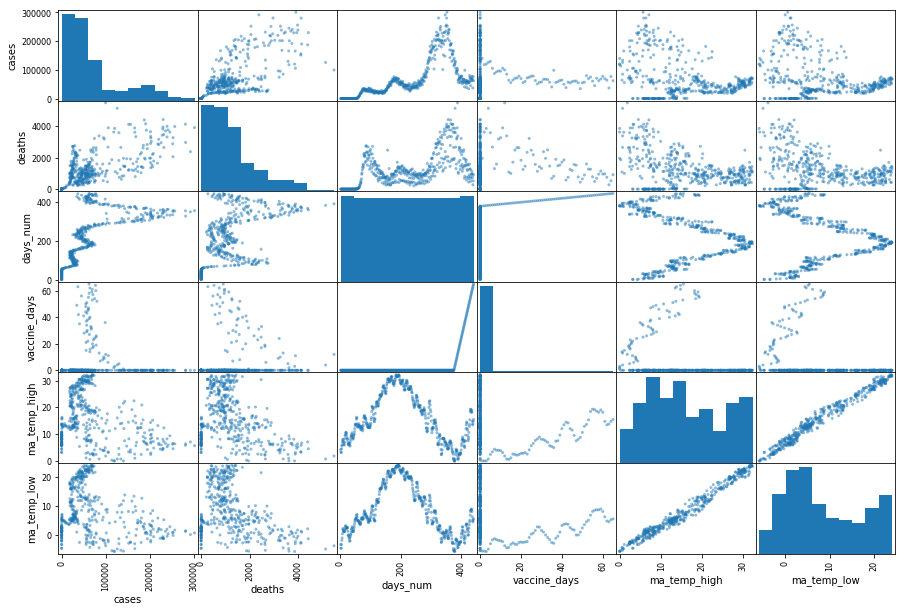

In [10]:
# ploting matrix to get insights from data columns relations
attributes = ['cases', 'deaths', 'days_num', 'vaccine_days', 'ma_temp_high', 'ma_temp_low']
pd.plotting.scatter_matrix(df[attributes], figsize=(15,10));

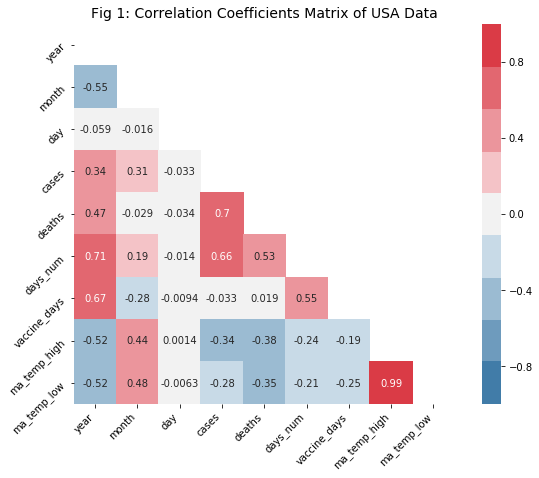

In [11]:
# To make the plot much bigger to make it clealy visible
plt.figure(figsize=(10,7))

# To build the matrix of correlation coefficient for all variables
corr_df = df.corr()

# To keep only the half of the matrix
mask = np.zeros_like(corr_df)
mask[np.triu_indices_from(mask)] = True

# To visualize the matrix
ax = sns.heatmap(
    corr_df, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(240, 10, n=9),
    annot=True,
    mask = mask,
    square=True)

# To set the labels of the axies
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right')
ax.set_yticklabels(
    ax.get_yticklabels(),
    rotation=45,
    horizontalalignment='right')

# To put a title on the polt
plt.title('Fig 1: Correlation Coefficients Matrix of USA Data', {'fontsize': 14, 'fontweight' : 5});

> **As we can see that the ma_temp_high and ma_temp_low is very corrlated to each other (0.99) so we are going to ignore temp_low because it's high correlated to another feature (temp_high)**

In [12]:
# drop ma_temp_low, year, month, day columns as it's not useful in the analysis
df.drop(['year','month','day','ma_temp_low'], axis=1, inplace=True)

# check
df.head(2)

,cases,deaths,days_num,vaccine_days,ma_temp_high
14,1,0,1,0,4.142857
15,0,0,2,0,3.142857


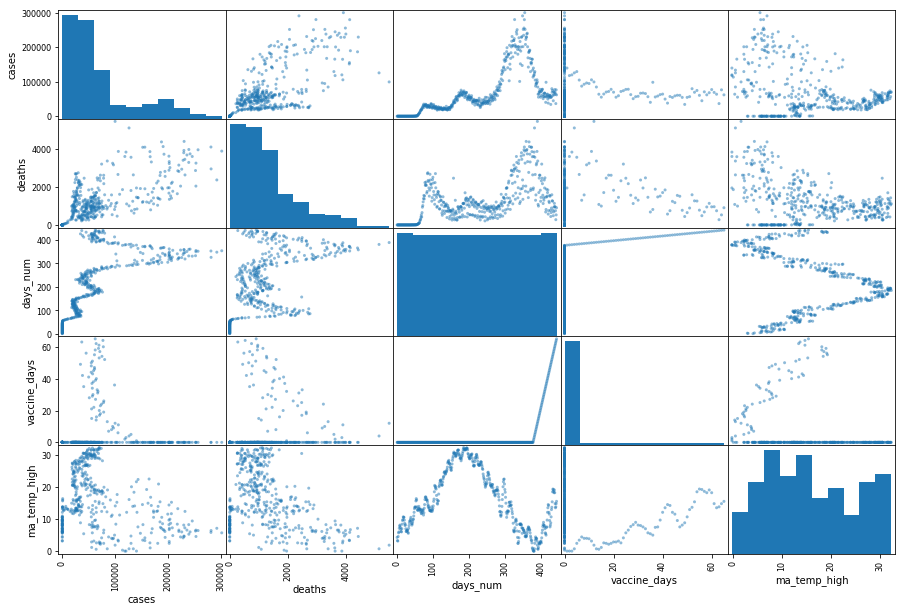

In [13]:
# ploting matrix to get insights from data columns relations
attributes = ['cases', 'deaths', 'days_num', 'vaccine_days', 'ma_temp_high']
pd.plotting.scatter_matrix(df[attributes], figsize=(15,10));

## 3. Data Preparing for ML model

### 3.1. Spliting the data into features and labels

In [14]:
# features
features = df[['days_num', 'vaccine_days', 'ma_temp_high']]

# check
features.head()

,days_num,vaccine_days,ma_temp_high
14,1,0,4.142857
15,2,0,3.142857
16,3,0,3.000000
17,4,0,4.428571
18,5,0,5.571429


In [15]:
# labels
labels = df[['cases', 'deaths']]

# check
labels.head()

,cases,deaths
14,1,0
15,0,0
16,0,0
17,1,0
18,1,0


### 3.2. Normlization Step

In [16]:
# normalizing the data
min_ = features.min()
max_ = features.max()
range_ = max_ - min_
features = (features - min_) / range_

# check
features.head()

,days_num,vaccine_days,ma_temp_high
14,0.000000,0.0,0.132159
15,0.002268,0.0,0.101322
16,0.004535,0.0,0.096916
17,0.006803,0.0,0.140969
18,0.009070,0.0,0.176211


### 3.3. Spliting the data into training and test datasets

In [17]:
# to split the data into two sets (one for training and one for testing)
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.17,random_state = 42)

# check the ratio
X_test.shape[0]/X_train.shape[0]

0.20765027322404372

## 4. Building the model

### 4.1. Building the linear regression model

In [18]:
# build and fit the model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [19]:
# predictions of applying the model on test_data
predictions = model.predict(X_test).astype('int')

# check (compare first five predictions and first five values of labels of test_data)
print(predictions[:5])
y_test.head()

[[125493   1957]
 [ 60313    984]
 [ 16414    684]
 [145982   2222]
 [ 19408    738]]


,cases,deaths
301,92416,1130
225,43013,1295
86,29717,1216
335,204292,1534
87,32318,1391


In [20]:
# the Standard divison of the test data and preditions
np.sqrt(mean_squared_error(y_test, predictions))

21712.775746665833

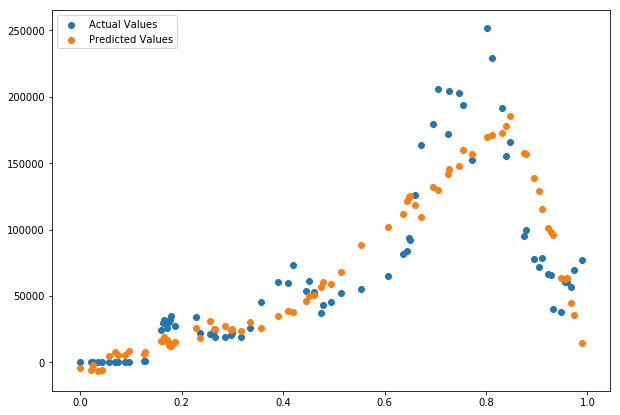

In [21]:
# To make the plot much bigger to make it clealy visible
plt.figure(figsize=(10,7))

# plotting the predictions vs the true values
plt.scatter(X_test.days_num, y_test.cases)
plt.scatter(X_test.days_num, predictions[:,0])
plt.legend(['Actual Values', 'Predicted Values'], loc=2);

>**STD = 21712, it's quite a good model but we are going to tune another model (Random Forest) to if we can get a better model**

>**Important Note: this model is close to realistic situation, the cases number is decreasing with increasing tempreture and the number of vaccinated people**

### 4.2. Svaing the linear regression model

In [22]:
joblib.dump(model, "LinearRegression_model.pkl")

['LinearRegression_model.pkl']

### 4.3. Building Grid Search to get best hyperparameters for Random Forest model

In [23]:
param_grid = [
    {'n_estimators': [1, 2, 3, 10, 15, 20] , 'max_features': [1, 2, 3]},
    {'bootstrap': [False], 'n_estimators': [1, 2, 10 ,20 ,30 ,40 ,50], 'max_features': [1, 2, 3]}
]

In [24]:
# tuning the parameters
model = RandomForestRegressor()
grid_search = GridSearchCV(model, param_grid, cv=2, scoring='neg_mean_squared_error', return_train_score = True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [1, 2, 3, 10, 15, 20], 'max_features': [1, 2, 3]}, {'bootstrap': [False], 'n_estimators': [1, 2, 10, 20, 30, 40, 50], 'max_features': [1, 2, 3]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [25]:
# get the best parameters
grid_search.best_params_

{'max_features': 3, 'n_estimators': 20}

In [26]:
# get the best model
final_model = grid_search.best_estimator_

In [27]:
# predictions of applying the final model on test_data
predictions = final_model.predict(X_test).astype('int')

# check (compare first five predictions and first five values of labels of test_data)
print(predictions[:5])
y_test.head()

[[115243   1507]
 [ 48027   1131]
 [ 25806   1097]
 [209278   2376]
 [ 30387   1392]]


,cases,deaths
301,92416,1130
225,43013,1295
86,29717,1216
335,204292,1534
87,32318,1391


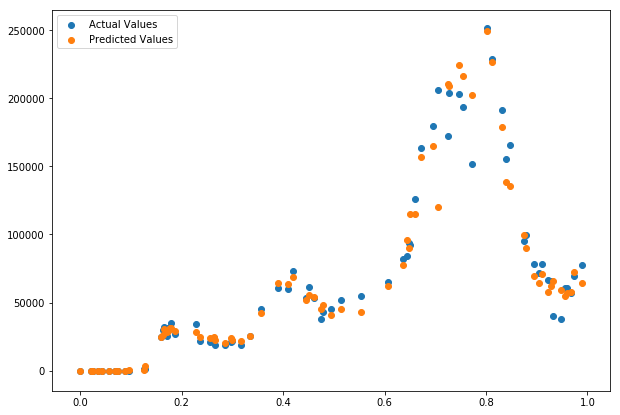

In [28]:
# To make the plot much bigger to make it clealy visible
plt.figure(figsize=(10,7))

# plotting the predictions vs the true values
plt.scatter(X_test.days_num, y_test.cases)
plt.scatter(X_test.days_num, predictions[:,0])
plt.legend(['Actual Values', 'Predicted Values'], loc=2);

In [29]:
# the Standard divison of the test data and preditions
np.sqrt(mean_squared_error(y_test, predictions))

10619.80343973862

>**STD = 10619, this model is better than the previous one but the model may be overfitting the data**

### 4.4. Svaing the random forest model

In [30]:
joblib.dump(final_model, "RandomForestRegressor_model.pkl")

['RandomForestRegressor_model.pkl']

> **Conclusion: we can say in the end that the linear regression model is more realistic and fitting the data more properly than the second one even with small STD becasue the second model is overfitting the data.**